In [1]:

# Read coordinate of inflated and sphere surface and find the vertex number at each node

import nibabel as nib
#import scipy as sc
import numpy as np
import pyvista as pv
import pandas as pd

# Read the inflated surface
frsurf = '/data/pt_02495/emprise7t/derivatives/freesurfer/'
file_inf_L = frsurf + 'fsaverage_fs/surf/lh.inflated'
file_sph_L = frsurf + 'fsaverage_fs/surf/lh.sphere'
file_inf_R = frsurf + 'fsaverage_fs/surf/rh.inflated'
file_sph_R = frsurf + 'fsaverage_fs/surf/rh.sphere'

# Subjects list
#subject = ['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '116']
subject = ['001','002','003','004','005','006','007','008','009','010','011','012']
session = ['audio']
model = 'True_False_iid_1_V2_new'


# nib.freesurfer.io.read_geometry(file) returns to a tuple of two numpy arrays: vertices and faces
# nib.freesurfer.io.read_geometry(file)[0] returns to 3 columns are the x, y, z coordinates of the vertices
# nib.freesurfer.io.read_geometry(file)[0] returns to 3 columns containing the indices of the vertices forming the face
inflated_L = nib.freesurfer.io.read_geometry(file_inf_L)
sphere_L = nib.freesurfer.io.read_geometry(file_sph_L) 
inflated_R = nib.freesurfer.io.read_geometry(file_inf_R)
sphere_R = nib.freesurfer.io.read_geometry(file_sph_R) 

# Order of vertices are preserved in the inflated and sphere surfaces.
# RAS based coordinate system is used in the inflated and sphere surfaces.
# The RAS coordinate of a vertex differs from the inflated and sphere surfaces. 
# Caution: For left hemisphere, increasing R heads to the medial part, 
#          and for right hemisphere, increasing R heads to the lateral part.
# Map the preferred numerosity map to the fsaverage sphere surface for our study,
# since the sphere surface has a uniform distribution (regular grid) of vertices.


# Calculate the gradient of scalar field.
# Load geometry data fsaverage

geo_lst = {'sl': sphere_L, 'sr':sphere_R, 'il':inflated_L, 'ir':inflated_R}
sp_list = ['sl', 'sr']

# Prepare dictionary to save the calculated gradients of each cluster for each subject
grad_dict = {}

# Prepare an array containing 
prog_total = {}

for sph in sp_list:
    face_sample = geo_lst[sph][1]  # 3 vertices composing a triangle
    vertice_num = np.full((face_sample.shape[0], 1), 3) 
    face = np.hstack((vertice_num, face_sample)) # add the number of vertices, here is 3
    face = face.flatten() # make a face data array such that [num.vertices, vertex1, vertex2, vertex3, num.vertices, vertex4, ..]

    # Create a pyvista mesh object
    mesh = pv.PolyData()
    mesh = pv.PolyData(geo_lst[sph][0], face)
    for ses in session:
        for s, sub in enumerate(subject):
            if sph == 'sl':
                hemi = 'hemi-L'
            elif sph == 'sr':
                hemi = 'hemi-R'
        # assgine a point data set of preffered numbers, mu
            path = f'/data/u_jeong_software/derivatives/numprf/sub-{sub}/ses-{ses}/model-{model}/'
            file = path + f'sub-{sub}_ses-{ses}_model-{model}_{hemi}_space-fsaverage_mu_thr-Rsqmb,0.2.surf.gii'
            mu = nib.load(file).darrays[0].data
    
            # mu=0 to nan
            print(f'Sub{sub}: Count of nan before correction is: ', np.count_nonzero(np.isnan(mu)))
    
            for i in range(mu.shape[0]):
                if mu[i]==0:
                    mu[i]=np.nan
                else:
                    pass
    
            print(f'Sub{sub}: Count of nan before correction is: ', np.count_nonzero(np.isnan(mu)))
    
            # Add scalar point set to the mesh
            mesh.point_data['mu'] = mu
    
            # Compute the gradient of the scalar point set
            # mu_deri = mesh.compute_derivative(scalars = 'mu') 
            
            mu_deri = np.zeros((mesh.points.shape[0],3))
    
            # calculate the gradient at a vertex - no parametric space of simplex and interpolation based on the shape of PolyData
            # - but compute it with respect to the direct neighbor vertices (connected with an edge)
    
            for vertex_index in range(mesh.points.shape[0]):
                
                if np.isnan(mesh['mu'][vertex_index]):
                    mu_deri[vertex_index,:] = np.nan
    
                else:
                    # Coordinates of the i-th vertex
                    v0 = mesh.points[vertex_index]
                    
                    # Indices of neighboring vertices (connected vertices)
                    neighbors_indices = mesh.point_neighbors(vertex_index)
                
                    # Filter out neighbors with NaN scalar values
                    valid_neighbors_indices = [i for i in neighbors_indices if not np.isnan(mesh['mu'][i])]
                    
                    # Coordinates of neighboring vertices
                    neighbors = mesh.points[valid_neighbors_indices]
                    
                    # Scalar values of neighboring vertices
                    neighbor_scalars = mesh['mu'][valid_neighbors_indices]
                    
                    # Difference vectors from the i-th vertex to its neighbors
                    diff_vectors = neighbors - v0
                    
                    # Scalar differences
                    scalar_diffs = neighbor_scalars - mesh['mu'][vertex_index]
                    
                    # Weighted sum of differences
                    weighted_sum = np.sum(scalar_diffs[:, np.newaxis] * diff_vectors, axis=0)
                    
                    # Sum of squared lengths of difference vectors
                    squared_lengths = np.sum(np.linalg.norm(diff_vectors, axis=1) ** 2)
                    
                    # Gradient calculation
                    gradient = weighted_sum/squared_lengths
                    
                    #print(f"Gradient at the vertex {vertex_index}:", gradient)
                    mu_deri[vertex_index,:] = gradient
    
            prog = mu_deri
    
            # Call the clustered data mu - it is the same as the previous data, with only thr applied. 
            clstmu_file = path + f'sub-{sub}_ses-{ses}_model-{model}_{hemi}_space-fsaverage_Rsq_thr-Rsqmb,0.2_cls-SurfClust_cls.surf.gii'
            clstmu = nib.load(clstmu_file).darrays[0].data
            
            # Use the cluster number to extract the vector info from the gradient
            # Prepare dictionary of clusters 
            clst = {}
            #for i in range(1,np.max(clsmu)+1):
                
    
            # Dictionary of clusters 
            # Prepare dictionary of clusters 
            clst = {}
            for i in range(1, np.max(clstmu) + 1):
                a = np.argwhere(clstmu == i)
                if a.size == 0:
                    clst[i] = []
                elif a.size == 1:
                    clst[i] = [a.item()]
                else:
                    clst[i] = np.squeeze(a).tolist()
            
            # A List of unwanted clusters, such that the number of vertices is less than 50
            '''        
            unwanted = [] 
            for i in range(np.max(clsmu)):
                if len(clst[i+1]) <= 50:
                    unwanted.append(i+1)
            '''
    
            """ 
            # Save the number of vertices in each cluster as pd.DataFrame
            clst_info = pd.DataFrame()
            clst_info['clst_index'] = list(clst.keys())
    
            num_vert = []
            for i in list(clst.keys()):
                num_vert.append(len(clst[i]))
                
            clst_info['num_ver'] = num_vert
    
            clst_info.to_csv(path + f'sub-{sub}_ses-{ses[0]}_model-{model}_{hemi}_space-fsaverage_Rsq_thr-Rsqmb,0.2_cls-SurfClust_cls.surf.csv', index=False)
            print(f'Sub{sub}, ses {ses[0]}, {hemi}: The number of clusters is: ', len(clst.keys()), ' and of vertices in it saved as csv file') 
            """
            
            # Calculate the directon of vector sum
            prog_array = np.column_stack((clstmu,mu))
            prog_array = np.column_stack((prog_array,prog))
            
            #clst_sum = {}   
            
            # {cluster index: [sum of x, sum of y, sum of z]}
            #for i in range(1,np.max(clstmu)+1):
            #   clst_sum[i] = [] 
            #   clst_sum[i].append(np.nansum(prog_array[clst[i],2]))
            #   clst_sum[i].append(np.nansum(prog_array[clst[i],3]))
            #   clst_sum[i].append(np.nansum(prog_array[clst[i],4]))
    
    
            # Save the vector sum of each cluster as pd.DataFrame
            """             
            summary = pd.DataFrame(clst_sum)
            summary = summary.T
            summary.columns = ['x','y','z']
            summary.to_csv(path + f'sub-{sub}_ses-{ses[0]}_model-{model}_{hemi}_space-fsaverage_Rsq_thr-Rsqmb,0.2_cls-SurfClust_cls.surf_vecprog.csv', index=False)
            print(f'Sub{sub}, ses {ses[0]}, {hemi} : The vector sum of each cluster is saved as csv file')
            """
            # Anatomy label of each cluster based on Destrieux Atlas 2009
            # Find the anatomy label using Destrieux Atlas 2009
            if sph == 'sl':
                hem = 'lh'
            elif sph == 'sr':
                hem = 'rh'
                
            filepath = frsurf + f'fsaverage_fs/label/{hem}.aparc.a2009s.annot'
            anot = nib.freesurfer.io.read_annot(filepath, orig_ids=False)
    
            # Find a anatomical label of a clust
            # anot[0] contains the number of label the vertex belongs to. If a vertex has no label, value is -1
            # anot[2] contains the name of the label
    
            prog_array = np.column_stack((prog_array,anot[0]))
            
            # Region of interest list
            # Visual
            #[b'S_postcentral', b'S_intrapariet_and_P_trans', b'G_parietal_sup', b'S_precentral-sup-part', b'S_oc_sup_and_transversal', b'S_occipital_ant']
            #list_ano = [anot[2][68],anot[2][57],anot[2][27],anot[2][70],anot[2][59],anot[2][60]]

            # Audio
            #['G_precentral','G_temp_sup-Lateral','G_temp_sup-Plan_tempo']
            list_ano = [anot[2][29],anot[2][34],anot[2][36]]
            
            anot_label = {}
            for i in list(clst.keys()):
                label_lst = anot[0][clst[i]]
                label_ind, counts = np.unique(label_lst, return_counts = True)
                label_name = []
                for ind in label_ind:
                    label_name.append(anot[2][ind])
                #anot_label['clust'+str(i)] = dict(zip(label_name, counts)) # To save it as a txt file
                anot_label[i] = dict(zip(label_name, counts)) # To save it as a dictionary value 
    
            # Save it as a txt file
            """         
            dir = f'/data/u_jeong_software/derivatives/numprf/sub-{sub}/ses-{ses[0]}/model-{model}/'
            with open(dir+f"cluster_ant_label_sub-{sub}_ses-{ses[0]}_hemi-{hemi}.txt", 'w') as f:  
                for key, value in anot_label.items():  
                    f.write('%s:%s\n' % (key, value))
            print(f'Sub{sub}, ses {ses[0]}, {hemi} : The anatomy label of each cluster is saved as txt file')
    
            """
            # Dictionary of clusters for each subject
            grad_dict[f'sub-{sub}_ses-{ses}_{hemi}'] = anot_label
            
            prog_xyz = {ano: [] for ano in list_ano}  
    
            #for j in clst.keys():
            for ano in list_ano:
                for j in clst.keys():
                    if ano in anot_label[j].keys() and anot_label[j][ano]/sum(list(anot_label[j].values())) > 0.5: # if it takes more than half of the cluster.
                        #if prog_dic[0][j] != [0.0, 0.0, 0.0]:  # Don't take clusters have only one preferred numerosity giving [0.0, 0.0, 0.0]
                        prog_xyz[ano].append((hemi,sub,j,mu_deri[clst[j],:])) # A tuple (hemi,subject,cluster number,gradient array) belongs to the anatomical region list_ano[i]
                    elif ano in anot_label[j].keys() and 0.25 < anot_label[j][ano]/sum(list(anot_label[j].values())) <= 0.5:
                        prog_xyz[ano].append((hemi,sub,j,mu_deri[clst[j],:]))  
                    else:
                        continue
                    
                if ano in prog_total:
                    prog_total[ano].extend(prog_xyz[ano])
                else:
                    prog_total[ano] = list(prog_xyz[ano])
    
            
                
            print(f'sub-{sub}_ses-{ses}_{hemi} dictionary of anatomical labels and gradients were saved as a dictionary and an array.')


Sub001: Count of nan before correction is:  121079
Sub001: Count of nan before correction is:  163302


/tmp/ipykernel_9147/1074520731.py:130: RuntimeWarning: invalid value encountered in divide
  gradient = weighted_sum/squared_lengths


sub-001_ses-audio_hemi-L dictionary of anatomical labels and gradients were saved as a dictionary and an array.
Sub002: Count of nan before correction is:  122157
Sub002: Count of nan before correction is:  163340
sub-002_ses-audio_hemi-L dictionary of anatomical labels and gradients were saved as a dictionary and an array.
Sub003: Count of nan before correction is:  118221
Sub003: Count of nan before correction is:  163101
sub-003_ses-audio_hemi-L dictionary of anatomical labels and gradients were saved as a dictionary and an array.
Sub004: Count of nan before correction is:  109457
Sub004: Count of nan before correction is:  163252
sub-004_ses-audio_hemi-L dictionary of anatomical labels and gradients were saved as a dictionary and an array.
Sub005: Count of nan before correction is:  103400
Sub005: Count of nan before correction is:  162908
sub-005_ses-audio_hemi-L dictionary of anatomical labels and gradients were saved as a dictionary and an array.
Sub006: Count of nan before corr

In [2]:
import pandas as pd

# Prepare data for DataFrame
data = []
for key, tuples in prog_total.items():
    for t in tuples:
        hemi, sub, cluster, array = t
        # Flatten the array into a list of lists
        for row in array:
            data.append([key, hemi, sub, cluster] + row.tolist())

# Define column names
columns = ['Key', 'Hemi', 'Subject', 'Cluster', 'R', 'A', 'S']

# Create DataFrame
df = pd.DataFrame(data, columns=columns)
df.to_csv('/data/pt_02495/emprise7t/derivatives/progression_summary_audio_adults.csv', index=False)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [169]:
# Statistics
data = pd.read_csv('/data/pt_02495/emprise7t/derivatives/progression_summary_adults.csv')

# Check the normality of the data
# Extract the unique key values
unique_keys = data['Key'].unique()
hemi_keys = data['Hemi'].unique()

# Specify the key to filter by
specific_key = unique_keys[5]   # Adjust the index as needed
specific_hemi = hemi_keys[1]



# numpy byte to string
# Convert numpy.byte_ object to bytes
# byte_string = bytes(specific_key)

# Decode bytes to string
#string = byte_string.decode('utf-8')
#print(string)

# Create the subset
subset = data[(data['Key'] == specific_key) & (data['Hemi'] == specific_hemi)]


In [170]:
# Load the dataset
#data = pd.read_csv('/data/pt_02495/emprise7t/derivatives/progression_summary_adults.csv')
#data = df

# Number of bootstrap samples
n_bootstraps = 10000

# Statistic of interest (e.g., mean)
observed_statistic_R = subset['R'].mean()
observed_statistic_A = subset['A'].mean()
observed_statistic_S = subset['S'].mean()

# Bootstrap resampling from the entire hemisphere
bootstrap_statistics_R = []
for _ in range(n_bootstraps):
    bootstrap_sample = data['R'].sample(len(subset), replace=True)
    bootstrap_statistics_R.append(bootstrap_sample.mean())

bootstrap_statistics_A= []
for _ in range(n_bootstraps):
    bootstrap_sample = data['A'].sample(len(subset), replace=True)
    bootstrap_statistics_A.append(bootstrap_sample.mean())

bootstrap_statistics_S = []
for _ in range(n_bootstraps):
    bootstrap_sample = data['S'].sample(len(subset), replace=True)
    bootstrap_statistics_S.append(bootstrap_sample.mean())

# Calculate p-value
bootstrap_statistics_R = np.array(bootstrap_statistics_R)
p_value_R = np.sum(bootstrap_statistics_R >= observed_statistic_R) / n_bootstraps

bootstrap_statistics_A = np.array(bootstrap_statistics_A)
p_value_A = np.sum(bootstrap_statistics_A >= observed_statistic_A) / n_bootstraps

bootstrap_statistics_S = np.array(bootstrap_statistics_S)
p_value_S = np.sum(bootstrap_statistics_S >= observed_statistic_S) / n_bootstraps



In [171]:
# confidence interval

alpha = 0.05  # Significance level for the confidence interval (95% confidence interval)
lower_percentile = alpha / 2 * 100
upper_percentile = (1 - alpha / 2) * 100
confidence_interval_R = np.percentile(bootstrap_statistics_R, [lower_percentile, upper_percentile])
confidence_interval_A = np.percentile(bootstrap_statistics_A, [lower_percentile, upper_percentile])
confidence_interval_S = np.percentile(bootstrap_statistics_S, [lower_percentile, upper_percentile])



S_occipital_ant


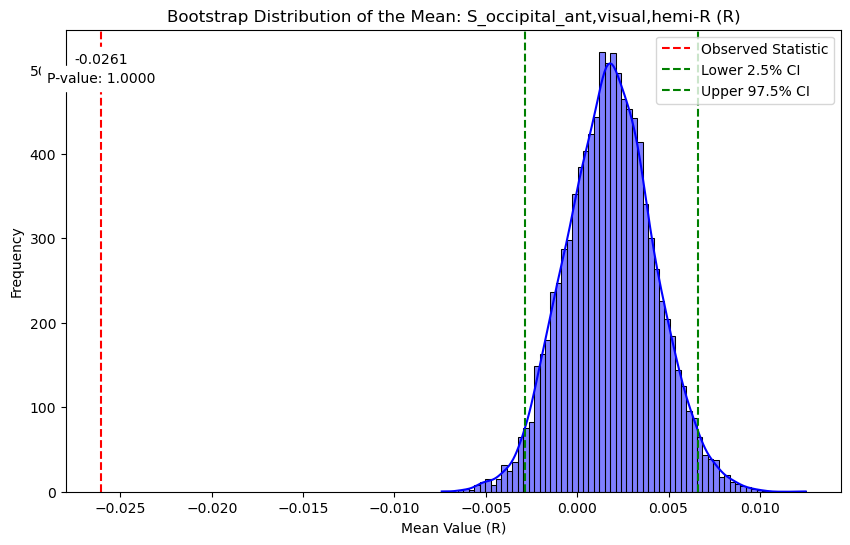

Observed Statistic: -0.026056693152383164
P-value: 1.0


In [172]:
# Plot the bootstrap distribution
ses = 'visual'

specific_key = specific_key[2:len(specific_key)-1]
print(specific_key)

plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_statistics_R, kde=True, color='blue')
plt.axvline(observed_statistic_R, color='red', linestyle='--', label = 'Observed Statistic')
plt.axvline(confidence_interval_R[0], color='green', linestyle='--', label=f'Lower {lower_percentile:.1f}% CI')
plt.axvline(confidence_interval_R[1], color='green', linestyle='--', label=f'Upper {upper_percentile:.1f}% CI')

# Add the value of the observed statistic next to the line
plt.text(observed_statistic_R, plt.gca().get_ylim()[1] * 0.95, f'{observed_statistic_R:.4f}', 
         color='black', ha='center', va='top', backgroundcolor='white')
plt.text(observed_statistic_R, plt.gca().get_ylim()[1] * 0.88,f'P-value: {p_value_R:.4f}',
         color='black', ha='center', va='bottom', backgroundcolor='white')
plt.title(f'Bootstrap Distribution of the Mean: {specific_key},{ses},{specific_hemi} (R)')
plt.xlabel('Mean Value (R)')
plt.ylabel('Frequency')
plt.legend()

plt.savefig('/data/u_jeong_software/EMPRISE/code/Python/Figure_Prog/'+f'{ses}_{specific_key}_{specific_hemi}_R.png')
plt.show()

print(f"Observed Statistic: {observed_statistic_R}")
print(f"P-value: {p_value_R}")

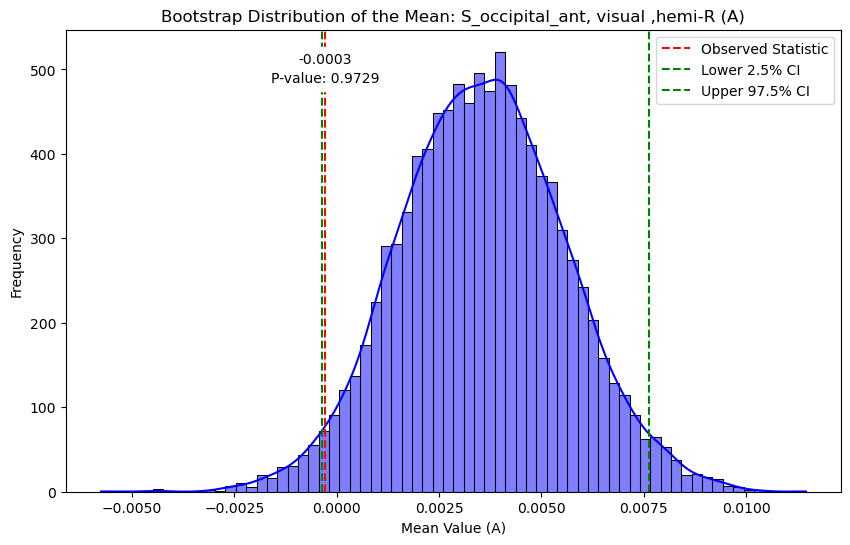

Observed Statistic: -0.00028611242760717703
P-value: 0.9729


In [173]:
# Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_statistics_A, kde=True, color='blue')
plt.axvline(observed_statistic_A, color='red', linestyle='--', label='Observed Statistic')
plt.axvline(confidence_interval_A[0], color='green', linestyle='--', label=f'Lower {lower_percentile:.1f}% CI')
plt.axvline(confidence_interval_A[1], color='green', linestyle='--', label=f'Upper {upper_percentile:.1f}% CI')

# Add the value of the observed statistic next to the line
plt.text(observed_statistic_A, plt.gca().get_ylim()[1] * 0.95, f'{observed_statistic_A:.4f}', 
         color='black', ha='center', va='top', backgroundcolor='white')
plt.text(observed_statistic_A, plt.gca().get_ylim()[1] * 0.88,f'P-value: {p_value_A:.4f}',
         color='black', ha='center', va='bottom', backgroundcolor='white')

plt.title(f'Bootstrap Distribution of the Mean: {specific_key}, {ses} ,{specific_hemi} (A)')
plt.xlabel('Mean Value (A)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('/data/u_jeong_software/EMPRISE/code/Python/Figure_Prog/'+f'{ses}_{specific_key}_{specific_hemi}_A.png')
plt.show()

print(f"Observed Statistic: {observed_statistic_A}")
print(f"P-value: {p_value_A}")

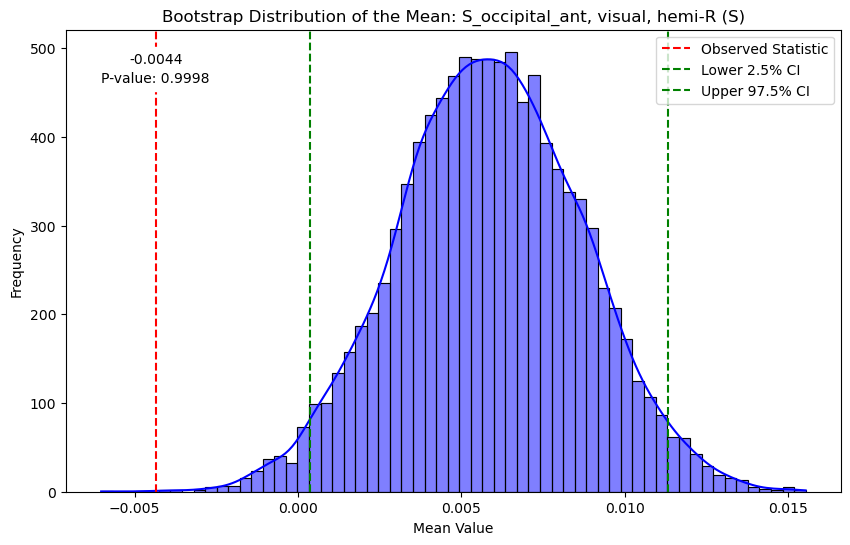

Observed Statistic: -0.004356823393700359
P-value: 0.9998


In [174]:
# Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_statistics_S, kde=True, color='blue')
plt.axvline(observed_statistic_S, color='red', linestyle='--', label='Observed Statistic')
plt.axvline(confidence_interval_S[0], color='green', linestyle='--', label=f'Lower {lower_percentile:.1f}% CI')
plt.axvline(confidence_interval_S[1], color='green', linestyle='--', label=f'Upper {upper_percentile:.1f}% CI')

# Add the value of the observed statistic next to the line
plt.text(observed_statistic_S, plt.gca().get_ylim()[1] * 0.95, f'{observed_statistic_S:.4f}', 
         color='black', ha='center', va='top', backgroundcolor='white')
plt.text(observed_statistic_S, plt.gca().get_ylim()[1] * 0.88,f'P-value: {p_value_S:.4f}',
         color='black', ha='center', va='bottom', backgroundcolor='white')

plt.title(f'Bootstrap Distribution of the Mean: {specific_key}, {ses}, {specific_hemi} (S)')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('/data/u_jeong_software/EMPRISE/code/Python/Figure_Prog/'+f'{ses}_{specific_key}_{specific_hemi}_S.png')
plt.show()

print(f"Observed Statistic: {observed_statistic_S}")
print(f"P-value: {p_value_S}")